### This notebook shows how to use different alignment algorithms to align two samples.

Install hacca library

In [1]:
# use pip to install hacca
%pip install ..

Processing i:\mutiomics\pythonproject
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for hacca: filename=hacca-0.0.5-py3-none-any.whl size=18450 sha256=605c394cd53636704a1d95c51e8473eb1e17b558f1da050a1902ec2059f193d7
  Stored in directory: C:\Users\28123\AppData\Local\Temp\pip-ephem-wheel-cache-_25w68we\wheels\f4\b6\c3\58ac8cb433abb98add080490f98bd85a3d5a576d67fc039979
Successfully built hacca
  Attempting uninstall: hacca
    Found existing installation: hacca 0.0.5
    Uninstalling hacca-0.0.5:
      Successfully uninstalled hacca-0.0.5
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import the necessary libraries

In [2]:
import scanpy as sc
import hacca
from hacca import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from STalign import STalign
## import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import plotly
import requests

# make plots bigger
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler


i:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


Load dataset. This example shows how to align two samples of `.h5ad` format.
- a_h5ad: sampled from sample A and feature X
- b_prime_h5ad: sampled from sample B and feature Y

And we want to get the alignment result (b_predict) using (a, b_prime) as input.

<img src="../asset/cmparision_notebook_notation.png" width="500">

Note that in this example, sample `A` and `B` are the same, therefore we have `a` equals `b`. So that we can use `a` as `b_truth` to evaluate the alignment performance of `b_predict`.

In [3]:
#### dir name
cwd=".."
data_path = os.path.join(cwd, 'data')
work_dir = os.path.join(cwd, 'work_test')
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

a_h5ad = sc.read_h5ad(os.path.join(data_path, "A1.h5ad"))
b_prime_h5ad = sc.read_h5ad(os.path.join(data_path,"A2.h5ad"))

The `spatial` column saves the raw location information of each cell in the original dataset before scaling and centering. and `clusters` save the cluster ID of each cell.

a AnnData object with n_obs × n_vars = 1000 × 2499
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
b_prime AnnData object with n_obs × n_vars = 1000 × 2500
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden', 'spatialX', 'spatialY'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


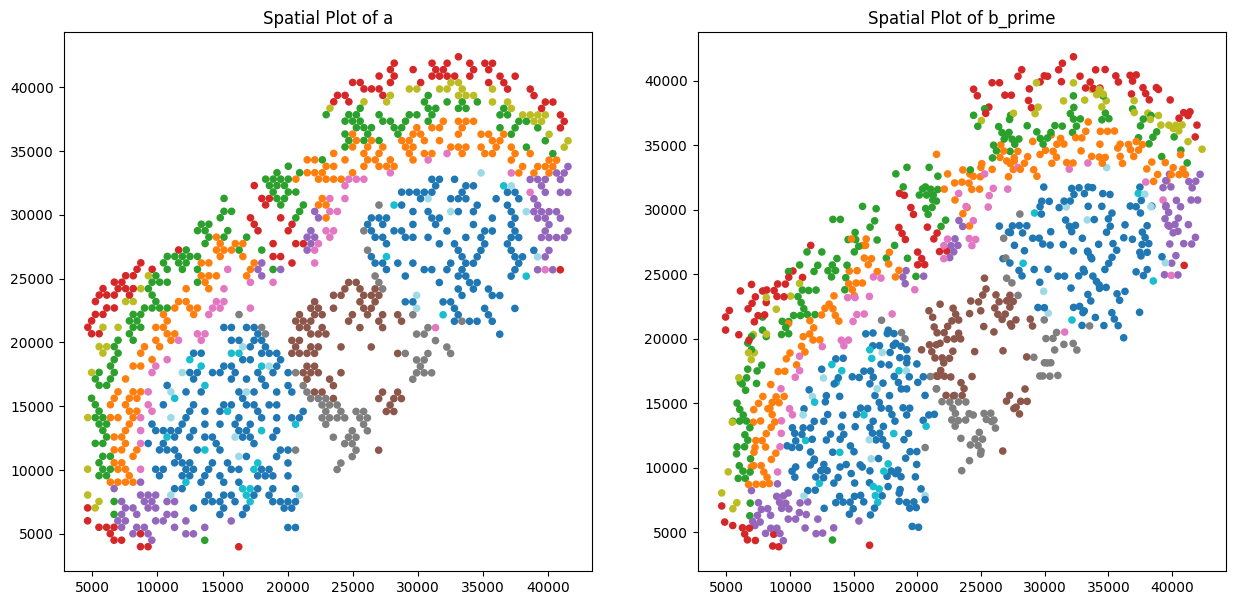

In [4]:
a_h5ad.obs["leiden"] = a_h5ad.obs["clusters"]
b_prime_h5ad.obs["leiden"] = b_prime_h5ad.obs["clusters"]
print("a",a_h5ad)
print("b_prime",b_prime_h5ad)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].scatter(a_h5ad.obsm["spatial"][:,0], a_h5ad.obsm["spatial"][:,1], c=a_h5ad.obs['leiden'].astype(int), cmap='tab20', s=20, alpha=1,)
axs[0].set_title('Spatial Plot of a')
axs[1].scatter(b_prime_h5ad.obsm["spatial"][:,0], b_prime_h5ad.obsm["spatial"][:,1], c=b_prime_h5ad.obs['leiden'].astype(int), cmap='tab20', s=20, alpha=1)
axs[1].set_title('Spatial Plot of b_prime')
plt.show()

Scale and center the location information of each cell in the original dataset. This step is optional.

In [5]:
b_prime_spatial = pd.DataFrame(b_prime_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(b_prime_spatial)
b_prime_spatial = pd.DataFrame(scaledata, columns=b_prime_spatial.columns).to_numpy()
a_spatial = pd.DataFrame(a_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(a_spatial)
a_spatial = pd.DataFrame(scaledata, columns=a_spatial.columns).to_numpy()

Create a `hacca.Data` object from original `.h5ad` files. A `hacca.Data` object is a triple of `(X, D, Label)` where:
- X: the feature matrix of the dataset
- D: the location information of each cell in the dataset
- Label: the cluster information of each cell in the dataset

In [6]:
a =  Data(X=a_h5ad.X.toarray(), D = a_spatial, Label=a_h5ad.obs['leiden'].to_numpy())
b_prime = Data(X=b_prime_h5ad.X.toarray(), D = b_prime_spatial, Label=b_prime_h5ad.obs['leiden'].to_numpy())
b_truth = a # use a as the ground truth to evaluate b_predict.

hacca packages provides the following alignment algorithms:
- manual_gross_alignment: rough alignment by manually providing three pairs of corresponding points
- further_alignment: further alignment by minimizing the distance between the corresponding points
- icp_2d_alignment: Iterative Closest Point (ICP) algorithm for 2D alignment using `data.D` as input
- icp_3d_alignment: Iterative Closest Point (ICP) algorithm for 3D alignment using `data.D` plus an additional dimension as the 3rd dimension. The additional dimension is calculated from `data.X`.
- fgw_2d_alignment: Fast Global Wasserstein (FGW) algorithm for 2D alignment using `data.D` as input
- fgw_3d_alignment: Fast Global Wasserstein (FGW) algorithm for 3D alignment using `data.D` plus an additional dimension as the 3rd dimension. The additional dimension is calculated from `data.X`.

Alignment pipeline 1: manual_gross_alignment | further_alignment | icp_3d_alignment | direct_alignment

i:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\alignment.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_.loc[:,'BprimeID'] = values
i:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\alignment.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_.loc[:,'AID'] = values


anchor_points_pairs 2978
unique_anchor_points_pairs 393


i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100
haCCA loss: (73.672745, 0.628, 0.4545776160648807), pairwise_alignment_accuracy: 0.6366530663673414


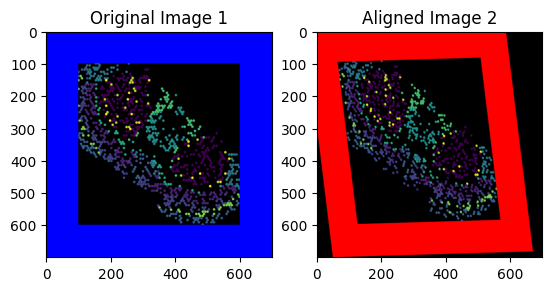

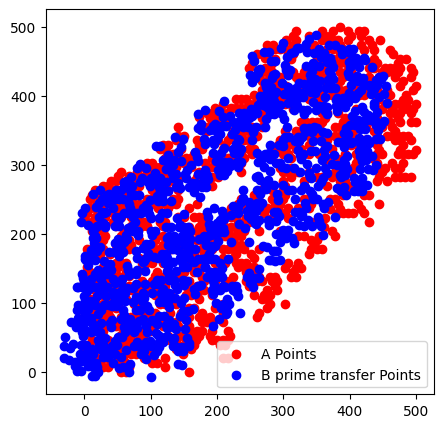

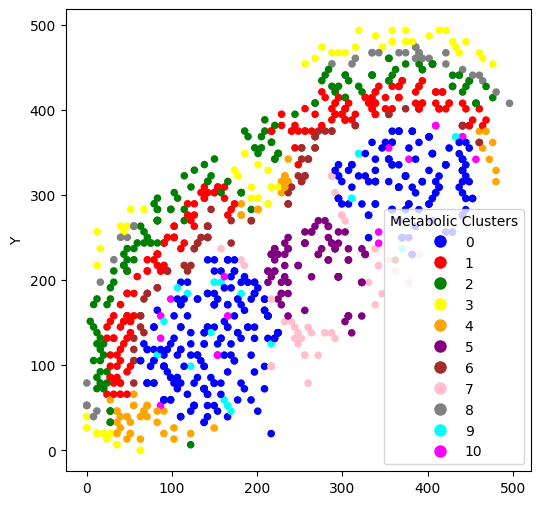

In [7]:
haCCA_work_dir = os.path.join(work_dir, 'haCCA')
if not os.path.exists(haCCA_work_dir):
    os.makedirs(haCCA_work_dir)
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=haCCA_work_dir)
_b_prime = hacca.further_alignment(a, _b_prime)
_a, _b_prime = hacca.icp_2d_with_feature_alignment(a, _b_prime)
b_preidct = hacca.direct_alignment(_a, _b_prime, work_dir=haCCA_work_dir)
b_predict_metric = hacca.direct_alignment_metric(_a, _b_prime)
haCCA = hacca.loss(b_preidct, b_truth)
hacca.plot_b_predict(b_preidct,haCCA_work_dir)
hacca_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(_a, _b_prime, b_predict_metric)
print(f"haCCA loss: {haCCA}, pairwise_alignment_accuracy: {hacca_pairwise_alignment_accuracy}")

Alignment pipeline 2: icp_3d_alignment | direct_alignment

anchor_points_pairs 4145
unique_anchor_points_pairs 424


i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100
ICP 3D: loss: (64.11106, 0.798, 0.6989669635887983), pairwise_alignment_accuracy: 0.7980583501936018


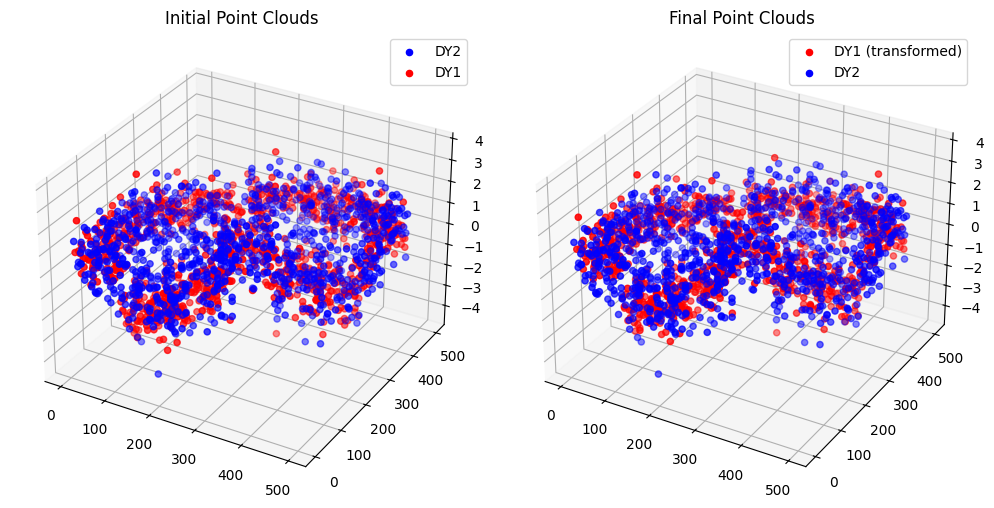

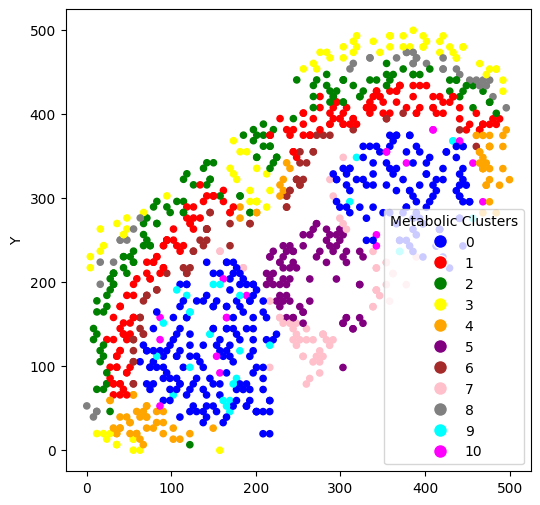

In [8]:
icp_3d_work_dir = os.path.join(work_dir, 'icp_3d')
if not os.path.exists(icp_3d_work_dir):
    os.makedirs(icp_3d_work_dir)
_a, _b_prime = hacca.icp_2d_with_feature_alignment(a, b_prime, icp_3d_work_dir)
b_predict = hacca.direct_alignment(_a, _b_prime, work_dir=icp_3d_work_dir)
b_predict_metric = hacca.direct_alignment_metric(_a, _b_prime)
hacca.plot_b_predict(b_predict, icp_3d_work_dir)
icp_3d_loss = hacca.loss(b_predict, b_truth)
icp_3d_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(_a, _b_prime, b_predict_metric)
print(f"ICP 3D: loss: {icp_3d_loss}, pairwise_alignment_accuracy: {icp_3d_pairwise_alignment_accuracy}")

Alignment pipeline 3: fgw_3d_alignment | direct_alignment

anchor_points_pairs 4145
unique_anchor_points_pairs 424


i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100
FGW 3D: loss: (106.13354, 0.444, 0.2365601046736677), fgw_3d_pairwise_alignment_accuracy: 0.44335860758901874


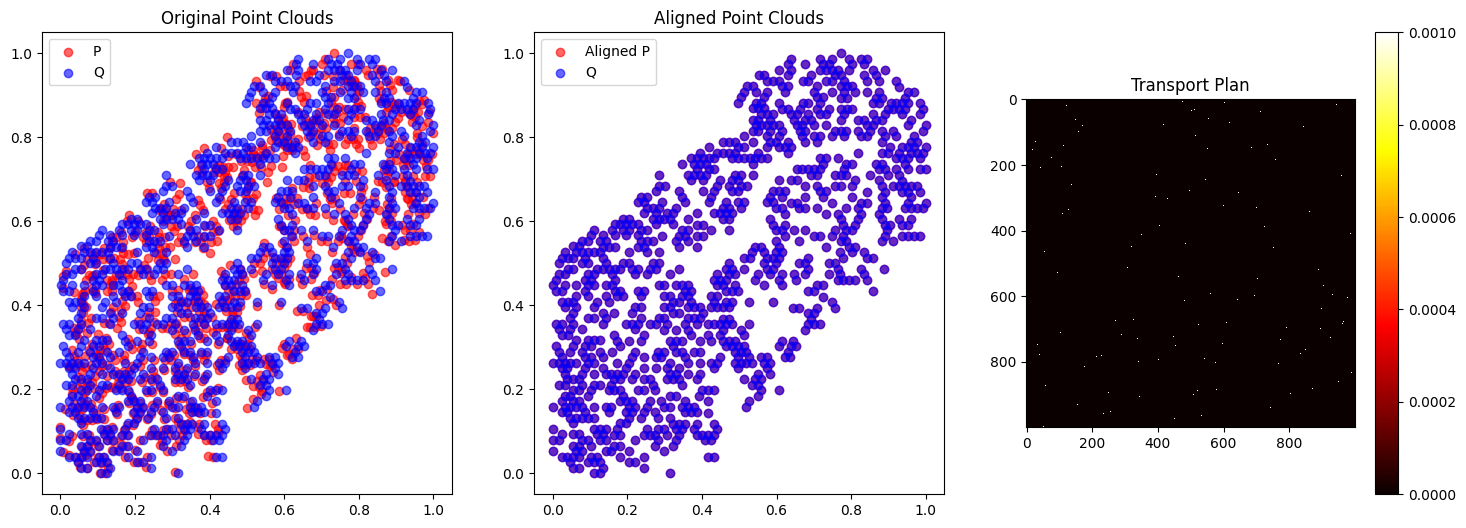

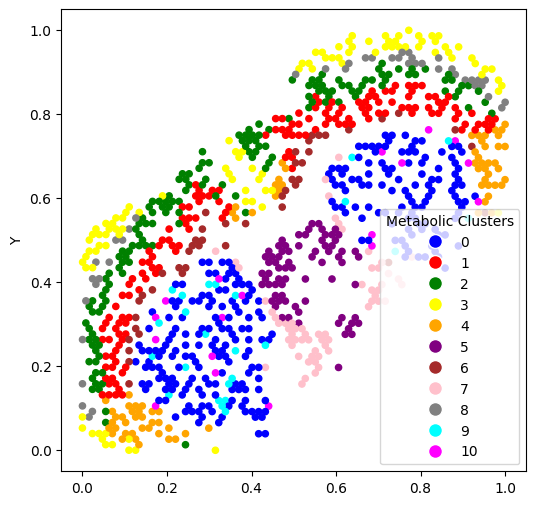

In [9]:
fgw_3d_work_dir = os.path.join(work_dir, 'fgw_3d')
if not os.path.exists(fgw_3d_work_dir):
        os.makedirs(fgw_3d_work_dir)
_a, _b_prime = hacca.fgw_3d_alignment(a, b_prime, fgw_3d_work_dir, alpha=0.8)
b_predict = hacca.direct_alignment(_a, _b_prime, work_dir=fgw_3d_work_dir)
pi = hacca.direct_alignment_metric(_a, _b_prime)
hacca.plot_b_predict(b_predict, fgw_3d_work_dir)
fgw_3d_loss = hacca.loss(b_predict, b_truth)
fgw_3d_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(_a, _b_prime, pi)
print(f"FGW 3D: loss: {fgw_3d_loss}, fgw_3d_pairwise_alignment_accuracy: {fgw_3d_pairwise_alignment_accuracy}")

Alignment pipeline 4: fgw_2d_alignment | direct_alignment

FGW 2D: loss: (55.991516, 0.883, 0.8192961476264753), pairwise_alignment_accuracy: 0.8808742971661894


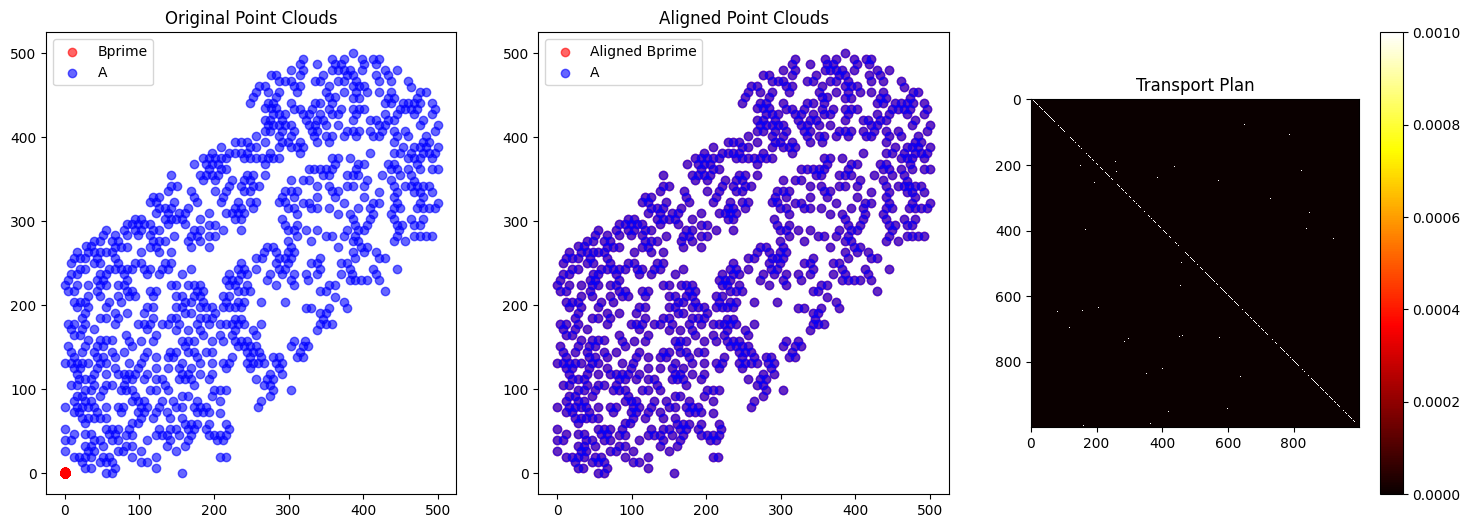

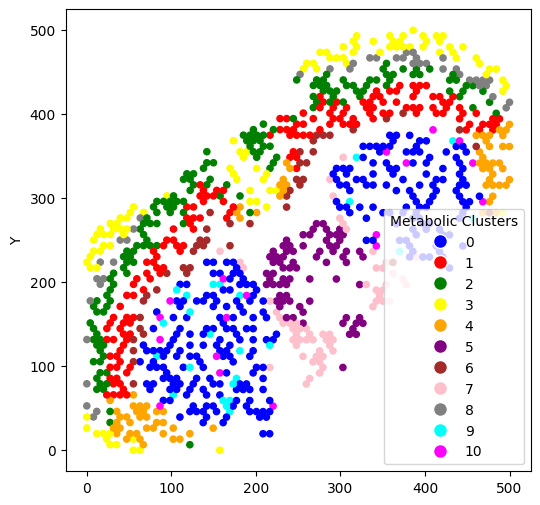

In [10]:
fgw_2d_work_dir = os.path.join(work_dir, 'fgw_2d')
if not os.path.exists(fgw_2d_work_dir):
        os.makedirs(fgw_2d_work_dir)
_b_prime = hacca.fgw_2d_alignment(a, b_prime, fgw_2d_work_dir)
b_predict = hacca.direct_alignment(a, _b_prime, work_dir=fgw_2d_work_dir)
pi = hacca.direct_alignment_metric(a, _b_prime)
hacca.plot_b_predict(b_predict, fgw_2d_work_dir)
fgw_2d_loss = hacca.loss(b_predict, b_truth)
fgw_2d_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(a, _b_prime, pi)
print(f"FGW 2D: loss: {fgw_2d_loss}, pairwise_alignment_accuracy: {fgw_2d_pairwise_alignment_accuracy}")

Alignment pipeline 5: icp_2d_alignment | direct_alignment

Converged after 22 iterations.
ICP 2D: loss: (66.407074, 0.797, 0.6959981683124736), pairwise_alignment_accuracy: 0.794045140908215


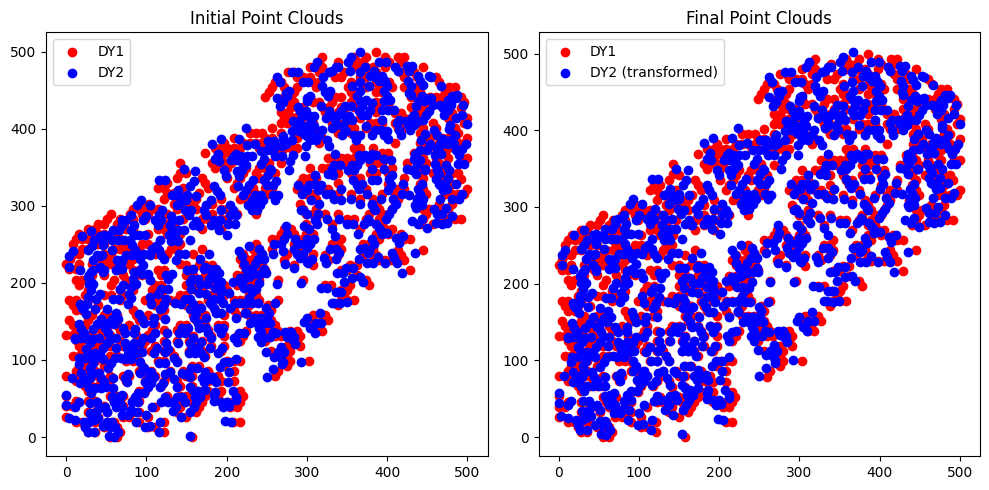

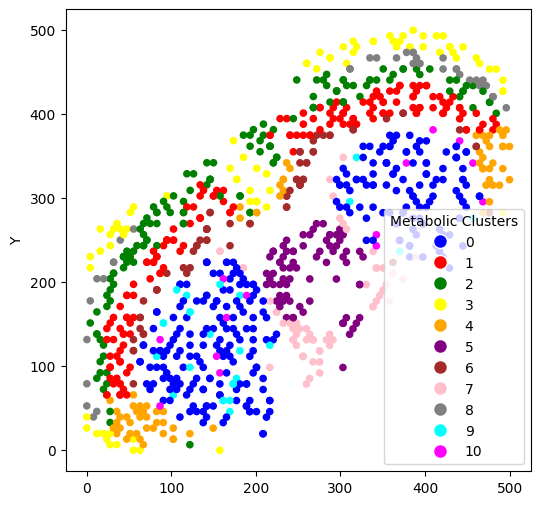

In [11]:
icp_2d_work_dir = os.path.join(work_dir, 'icp_2d')
if not os.path.exists(icp_2d_work_dir):
    os.makedirs(icp_2d_work_dir)

_b_prime = hacca.icp_2d_alignment(a, b_prime, icp_2d_work_dir)
b_predict = hacca.direct_alignment(a, _b_prime, work_dir=icp_2d_work_dir)
hacca.plot_b_predict(b_predict, icp_2d_work_dir)
pi = hacca.direct_alignment_metric(a, _b_prime)
icp_2d_loss = hacca.loss(b_predict, b_truth)
icp_2d_dir_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(a, _b_prime, pi)
print(f"ICP 2D: loss: {icp_2d_loss}, pairwise_alignment_accuracy: {icp_2d_dir_pairwise_alignment_accuracy}")

Alignment pipeline 6: direct_alignment

Direct alignment w/ center and scale: loss: (71.50197, 0.762, 0.6593195054939169), pairwise_alignment_accuracy: 0.7682690115142057


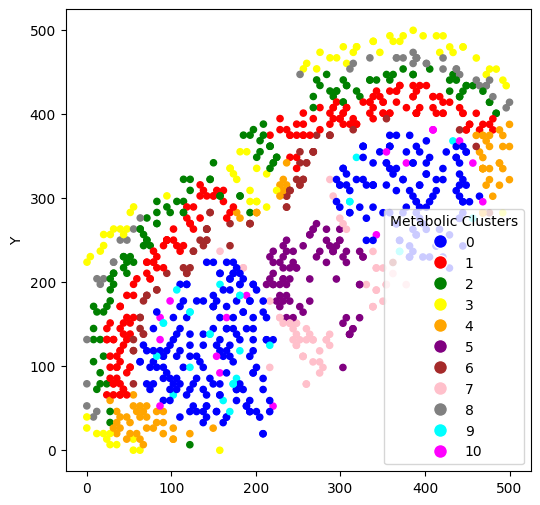

In [12]:
direct_alignment_work_dir = os.path.join(work_dir, 'direct_alignment')
if not os.path.exists(direct_alignment_work_dir):
    os.makedirs(direct_alignment_work_dir)
    
b_predict = hacca.direct_alignment(a, b_prime, direct_alignment_work_dir)
pi = hacca.direct_alignment_metric(a, b_prime)
hacca.plot_b_predict(b_predict, direct_alignment_work_dir)
direct_alignment_loss = hacca.loss(b_predict, b_truth)
direct_alignment_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(a, b_prime, pi)
print(f"Direct alignment w/ center and scale: loss: {direct_alignment_loss}, pairwise_alignment_accuracy: {direct_alignment_pairwise_alignment_accuracy}")

Alignment pipeline 7: manual_gross_alignment | direct_alignment

manual_alignment: loss: (82.83608, 0.642, 0.459522054046258), pairwise_alignment_accuracy: 0.6455208333795347


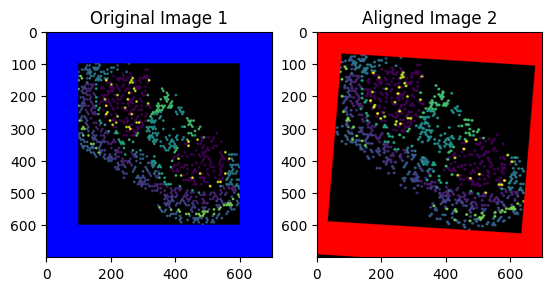

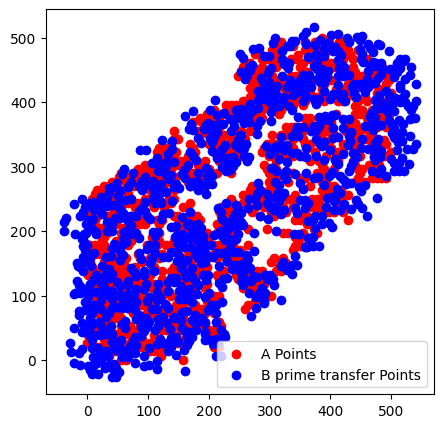

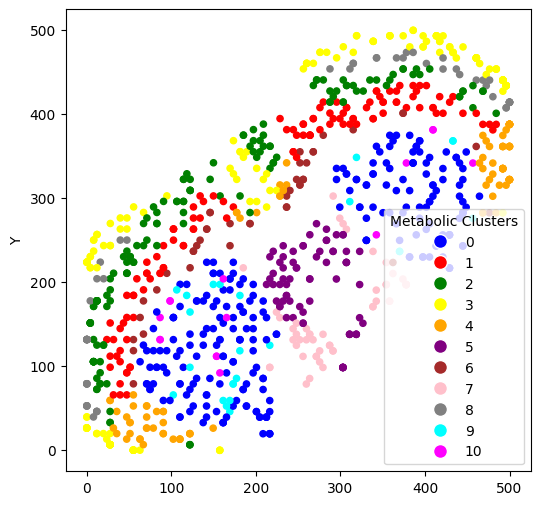

In [13]:
manual_alignment_work_dir = os.path.join(work_dir, 'manual alignment')
if not os.path.exists(manual_alignment_work_dir):
    os.makedirs(manual_alignment_work_dir)
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=manual_alignment_work_dir)
b_preidct = hacca.direct_alignment(a, _b_prime, work_dir=manual_alignment_work_dir)
pi = hacca.direct_alignment_metric(a, _b_prime)
manual_alignment = hacca.loss(b_preidct, b_truth)
manual_alignment_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(a, _b_prime, pi)
print(f"manual_alignment: loss: {manual_alignment}, pairwise_alignment_accuracy: {manual_alignment_pairwise_alignment_accuracy}")
hacca.plot_b_predict(b_preidct,manual_alignment_work_dir)

Alignment pipeline 8: icp_3d_alignment | fgw_3d_alignment | direct_alignment

anchor_points_pairs 6958
unique_anchor_points_pairs 462


i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100
Run ICP2D_FGW3D alignment: loss: (55.991516, 0.883, 0.8192961476264753), pairwise_alignment_accuracy: 0.8808597762260466


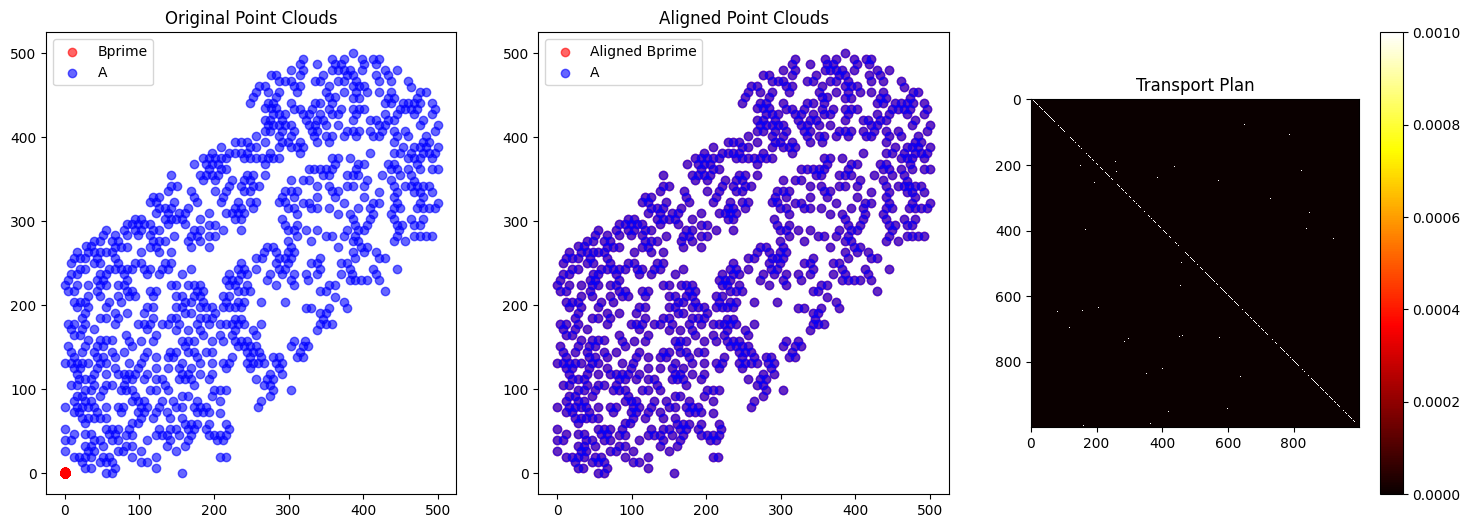

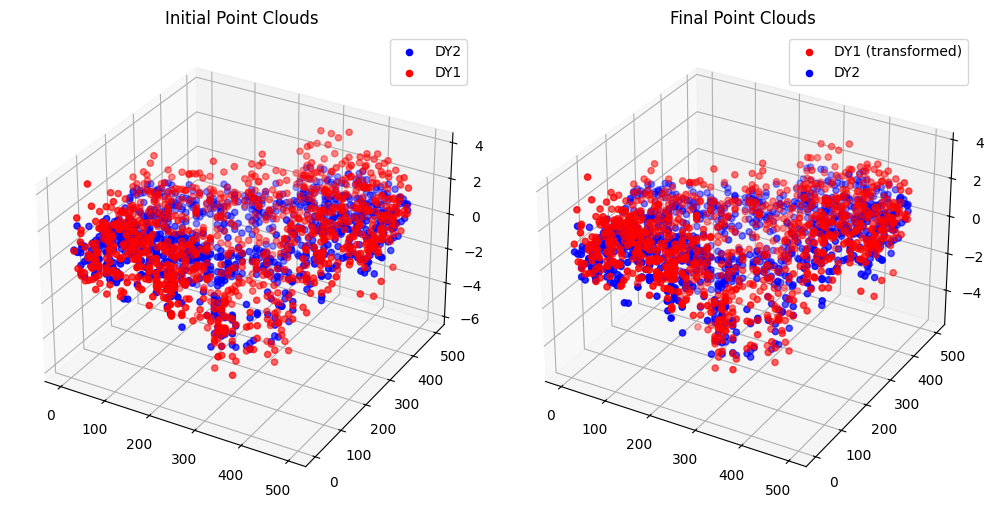

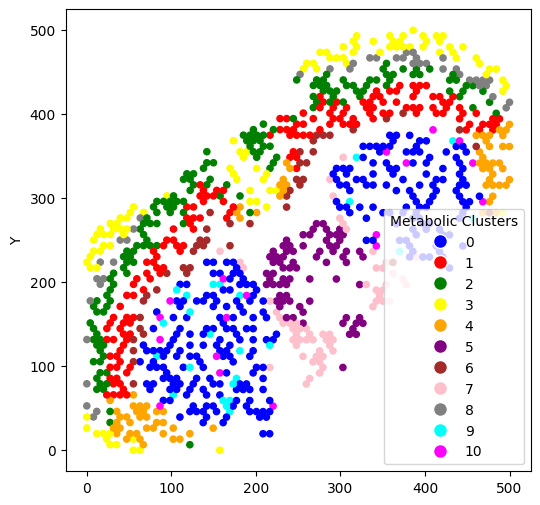

In [14]:
ICP2D_FGW3D_alignment_work_dir = os.path.join(work_dir, 'ICP2D_FGW3D')
if not os.path.exists(ICP2D_FGW3D_alignment_work_dir):
    os.makedirs(ICP2D_FGW3D_alignment_work_dir)
    
_b_prime = hacca.fgw_2d_alignment(a, b_prime, ICP2D_FGW3D_alignment_work_dir)
_a, _b_prime = hacca.icp_2d_with_feature_alignment(a, _b_prime, ICP2D_FGW3D_alignment_work_dir)
b_predict = hacca.direct_alignment(_a, _b_prime, ICP2D_FGW3D_alignment_work_dir)
pi = hacca.direct_alignment_metric(_a, _b_prime)
hacca.plot_b_predict(b_predict, ICP2D_FGW3D_alignment_work_dir)
ICD2D_FGW3D_alignment_loss = hacca.loss(b_predict, b_truth)
ICD2D_FGW3D_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(_a, _b_prime, pi)
print(f"Run ICP2D_FGW3D alignment: loss: {ICD2D_FGW3D_alignment_loss}, pairwise_alignment_accuracy: {ICD2D_FGW3D_pairwise_alignment_accuracy}")

Alignment pipeline 9: STalign

0 of 1000
999 of 1000
0 of 1000
999 of 1000


i:\mutiomics\pythonProject\.venv\lib\site-packages\torch\cuda\__init__.py:173: UserWarning: 
NVIDIA GeForce RTX 5070 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5070 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
i:\mutiomics\pythonProject\.venv\lib\site-packages\STalign\STalign.py:1043: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
i:\mutiomics\pythonProject\.venv\lib\site-packages\STalign\STalign.py:1044: UserWarning: T

RuntimeError: 
  #ifdef __HIPCC__
  #define ERROR_UNSUPPORTED_CAST ;
  // corresponds to aten/src/ATen/native/cuda/thread_constants.h
  #define CUDA_OR_ROCM_NUM_THREADS 256
  // corresponds to aten/src/ATen/cuda/detail/OffsetCalculator.cuh
  #define MAX_DIMS 16
  #ifndef __forceinline__
  #define __forceinline__ inline __attribute__((always_inline))
  #endif
  #else
  //TODO use _assert_fail, because assert is disabled in non-debug builds
  #define ERROR_UNSUPPORTED_CAST assert(false);
  #define CUDA_OR_ROCM_NUM_THREADS 128
  #define MAX_DIMS 25
  #endif
  #define POS_INFINITY __int_as_float(0x7f800000)
  #define INFINITY POS_INFINITY
  #define NEG_INFINITY __int_as_float(0xff800000)
  #define NAN __int_as_float(0x7fffffff)

  typedef long long int int64_t;
  typedef unsigned int uint32_t;
  typedef signed char int8_t;
  typedef unsigned char uint8_t;  // NOTE: this MUST be "unsigned char"! "char" is equivalent to "signed char"
  typedef short int16_t;
  static_assert(sizeof(int64_t) == 8, "expected size does not match");
  static_assert(sizeof(uint32_t) == 4, "expected size does not match");
  static_assert(sizeof(int8_t) == 1, "expected size does not match");
  constexpr int num_threads = CUDA_OR_ROCM_NUM_THREADS;
  constexpr int thread_work_size = 4; // TODO: make template substitution once we decide where those vars live
  constexpr int block_work_size = thread_work_size * num_threads;

  
  
  namespace std {
  
  template <class _Tp>
  _Tp&& __declval(int);
  template <class _Tp>
  _Tp __declval(long);
  template <class _Tp>
  decltype(__declval<_Tp>(0)) declval() noexcept;
  
  template <class _Tp, _Tp __v>
  struct integral_constant {
    static const _Tp value = __v;
    typedef _Tp value_type;
    typedef integral_constant type;
  };
  
  typedef integral_constant<bool, true> true_type;
  typedef integral_constant<bool, false> false_type;
  
  // is_same, functional
  template <class _Tp, class _Up> struct is_same : public false_type {};
  template <class _Tp> struct is_same<_Tp, _Tp> : public true_type {};
  
  // is_integral, for some types.
  template <class _Tp> struct is_integral
      : public integral_constant<bool, false> {};
  template <> struct is_integral<bool>
      : public integral_constant<bool, true> {};
  template <> struct is_integral<char>
      : public integral_constant<bool, true> {};
  template <> struct is_integral<short>
      : public integral_constant<bool, true> {};
  template <> struct is_integral<int>
      : public integral_constant<bool, true> {};
  template <> struct is_integral<long>
      : public integral_constant<bool, true> {};
  template <> struct is_integral<long long>
      : public integral_constant<bool, true> {};
  
  // enable_if, functional
  template <bool _C, typename _Tp> struct enable_if{};
  template <typename _Tp> struct enable_if<true, _Tp>{
    using type = _Tp;
  };
  template <bool b, class T=void>
  using enable_if_t = typename enable_if<b,T>::type;
  
  template <class _Tp> struct remove_const            {typedef _Tp type;};
  template <class _Tp> struct remove_const<const _Tp> {typedef _Tp type;};
  template <class _Tp> using remove_const_t = typename remove_const<_Tp>::type;
  
  template <class _Tp> struct remove_volatile               {typedef _Tp type;};
  template <class _Tp> struct remove_volatile<volatile _Tp> {typedef _Tp type;};
  template <class _Tp> using remove_volatile_t = typename remove_volatile<_Tp>::type;
  
  template <class _Tp> struct remove_cv
  {typedef typename remove_volatile<typename remove_const<_Tp>::type>::type type;};
  template <class _Tp> using remove_cv_t = typename remove_cv<_Tp>::type;
  
  template <class _Tp> struct __libcpp_is_floating_point              : public false_type {};
  template <>          struct __libcpp_is_floating_point<float>       : public true_type {};
  template <>          struct __libcpp_is_floating_point<double>      : public true_type {};
  template <>          struct __libcpp_is_floating_point<long double> : public true_type {};
  
  template <class _Tp> struct is_floating_point
      : public __libcpp_is_floating_point<typename remove_cv<_Tp>::type> {};
  
  template <class _Tp> struct is_arithmetic
      : public integral_constant<bool, is_integral<_Tp>::value      ||
                                       is_floating_point<_Tp>::value> {};
  template <class _Tp>
  inline constexpr bool is_arithmetic_v = is_arithmetic<_Tp>::value;
  
  template <class _Tp>
  struct __numeric_type
  {
     static void __test(...);
     static float __test(float);
     static double __test(char);
     static double __test(int);
     static double __test(unsigned);
     static double __test(long);
     static double __test(unsigned long);
     static double __test(long long);
     static double __test(unsigned long long);
     static double __test(double);
     static long double __test(long double);
  
     typedef decltype(__test(declval<_Tp>())) type;
     static const bool value = !is_same<type, void>::value;
  };
  
  template <>
  struct __numeric_type<void>
  {
     static const bool value = true;
  };
  
  // __promote
  
  template <class _A1, class _A2 = void, class _A3 = void,
            bool = __numeric_type<_A1>::value &&
                   __numeric_type<_A2>::value &&
                   __numeric_type<_A3>::value>
  class __promote_imp
  {
  public:
      static const bool value = false;
  };
  
  template <class _A1, class _A2, class _A3>
  class __promote_imp<_A1, _A2, _A3, true>
  {
  private:
      typedef typename __promote_imp<_A1>::type __type1;
      typedef typename __promote_imp<_A2>::type __type2;
      typedef typename __promote_imp<_A3>::type __type3;
  public:
      typedef decltype(__type1() + __type2() + __type3()) type;
      static const bool value = true;
  };
  
  template <class _A1, class _A2>
  class __promote_imp<_A1, _A2, void, true>
  {
  private:
      typedef typename __promote_imp<_A1>::type __type1;
      typedef typename __promote_imp<_A2>::type __type2;
  public:
      typedef decltype(__type1() + __type2()) type;
      static const bool value = true;
  };
  
  template <class _A1>
  class __promote_imp<_A1, void, void, true>
  {
  public:
      typedef typename __numeric_type<_A1>::type type;
      static const bool value = true;
  };
  
  template <class _A1, class _A2 = void, class _A3 = void>
  class __promote : public __promote_imp<_A1, _A2, _A3> {};
  
  } // namespace std
  
  
  
  
  namespace std {
  
  using ::signbit;
  using ::isfinite;
  using ::isinf;
  using ::isnan;
  
  using ::abs;
  
  using ::acos;
  using ::acosf;
  using ::asin;
  using ::asinf;
  using ::atan;
  using ::atanf;
  using ::atan2;
  using ::atan2f;
  using ::ceil;
  using ::ceilf;
  using ::cos;
  using ::cosf;
  using ::cosh;
  using ::coshf;
  
  using ::exp;
  using ::expf;
  
  using ::fabs;
  using ::fabsf;
  using ::floor;
  using ::floorf;
  
  using ::fmod;
  using ::fmodf;
  
  using ::frexp;
  using ::frexpf;
  using ::ldexp;
  using ::ldexpf;
  
  using ::log;
  using ::logf;
  
  using ::log10;
  using ::log10f;
  using ::modf;
  using ::modff;
  
  using ::pow;
  using ::powf;
  
  using ::sin;
  using ::sinf;
  using ::sinh;
  using ::sinhf;
  
  using ::sqrt;
  using ::sqrtf;
  using ::tan;
  using ::tanf;
  
  using ::tanh;
  using ::tanhf;
  
  using ::acosh;
  using ::acoshf;
  using ::asinh;
  using ::asinhf;
  using ::atanh;
  using ::atanhf;
  using ::cbrt;
  using ::cbrtf;
  
  using ::copysign;
  using ::copysignf;
  
  using ::erf;
  using ::erff;
  using ::erfc;
  using ::erfcf;
  using ::exp2;
  using ::exp2f;
  using ::expm1;
  using ::expm1f;
  using ::fdim;
  using ::fdimf;
  using ::fmaf;
  using ::fma;
  using ::fmax;
  using ::fmaxf;
  using ::fmin;
  using ::fminf;
  using ::hypot;
  using ::hypotf;
  using ::ilogb;
  using ::ilogbf;
  using ::lgamma;
  using ::lgammaf;
  using ::llrint;
  using ::llrintf;
  using ::llround;
  using ::llroundf;
  using ::log1p;
  using ::log1pf;
  using ::log2;
  using ::log2f;
  using ::logb;
  using ::logbf;
  using ::lrint;
  using ::lrintf;
  using ::lround;
  using ::lroundf;
  
  using ::nan;
  using ::nanf;
  
  using ::nearbyint;
  using ::nearbyintf;
  using ::nextafter;
  using ::nextafterf;
  using ::remainder;
  using ::remainderf;
  using ::remquo;
  using ::remquof;
  using ::rint;
  using ::rintf;
  using ::round;
  using ::roundf;
  using ::scalbln;
  using ::scalblnf;
  using ::scalbn;
  using ::scalbnf;
  using ::tgamma;
  using ::tgammaf;
  using ::trunc;
  using ::truncf;
  
  } // namespace std
  
  

  // NB: Order matters for this macro; it is relied upon in
  // _promoteTypesLookup and the serialization format.
  // Note, some types have ctype as void because we don't support them in codegen
  #define AT_FORALL_SCALAR_TYPES_WITH_COMPLEX(_) \
  _(uint8_t, Byte) /* 0 */                               \
  _(int8_t, Char) /* 1 */                                \
  _(int16_t, Short) /* 2 */                              \
  _(int, Int) /* 3 */                                    \
  _(int64_t, Long) /* 4 */                               \
  _(at::Half, Half) /* 5 */                                  \
  _(float, Float) /* 6 */                                \
  _(double, Double) /* 7 */                              \
  _(std::complex<at::Half>, ComplexHalf) /* 8 */        \
  _(std::complex<float>, ComplexFloat) /* 9 */                          \
  _(std::complex<double>, ComplexDouble) /* 10 */                         \
  _(bool, Bool) /* 11 */                                 \
  _(void, QInt8) /* 12 */                          \
  _(void, QUInt8) /* 13 */                        \
  _(void, QInt32) /* 14 */                        \
  _(at::BFloat16, BFloat16) /* 15 */                             \

  #define AT_FORALL_SCALAR_TYPES_WITH_COMPLEX_EXCEPT_QINT(_)       \
  _(uint8_t, Byte)                                                 \
  _(int8_t, Char)                                                  \
  _(int16_t, Short)                                                \
  _(int, Int)                                                      \
  _(int64_t, Long)                                                 \
  _(at::Half, Half)                                                \
  _(float, Float)                                                  \
  _(double, Double)                                                \
  _(std::complex<at::Half>, ComplexHalf)                           \
  _(std::complex<float>, ComplexFloat)                             \
  _(std::complex<double>, ComplexDouble)                           \
  _(bool, Bool)                                                    \
  _(at::BFloat16, BFloat16)


  enum class ScalarType : int8_t {
  #define DEFINE_ENUM(_1, n) n,
  AT_FORALL_SCALAR_TYPES_WITH_COMPLEX(DEFINE_ENUM)
  #undef DEFINE_ENUM
      Undefined,
  NumOptions
  };

  template <typename T, int size>
  struct Array {
  T data[size];

  __device__ T operator[](int i) const {
      return data[i];
  }
  __device__ T& operator[](int i) {
      return data[i];
  }
  Array() = default;
  Array(const Array&) = default;
  Array& operator=(const Array&) = default;
  __device__ Array(T x) {
    for (int i = 0; i < size; i++) {
      data[i] = x;
    }
  }
  };

  
  
  
  
  namespace std {
  
  template<class _Tp> class complex;
  
  template<class _Tp> complex<_Tp> operator*(const complex<_Tp>& __z, const complex<_Tp>& __w);
  template<class _Tp> complex<_Tp> operator/(const complex<_Tp>& __x, const complex<_Tp>& __y);
  
  template<class _Tp>
  class complex
  {
  public:
      typedef _Tp value_type;
  private:
      value_type __re_;
      value_type __im_;
  public:
      constexpr
      complex(const value_type& __re = value_type(), const value_type& __im = value_type())
          : __re_(__re), __im_(__im) {}
      template<class _Xp> constexpr
      complex(const complex<_Xp>& __c)
          : __re_(__c.real()), __im_(__c.imag()) {}
  
      constexpr value_type real() const {return __re_;}
      constexpr value_type imag() const {return __im_;}
  
      void real(value_type __re) {__re_ = __re;}
      void imag(value_type __im) {__im_ = __im;}
  
      constexpr operator bool() const {
          return real() || imag();
      }
  
      complex& operator= (const value_type& __re)
          {__re_ = __re; __im_ = value_type(); return *this;}
      complex& operator+=(const value_type& __re) {__re_ += __re; return *this;}
      complex& operator-=(const value_type& __re) {__re_ -= __re; return *this;}
      complex& operator*=(const value_type& __re) {__re_ *= __re; __im_ *= __re; return *this;}
      complex& operator/=(const value_type& __re) {__re_ /= __re; __im_ /= __re; return *this;}
  
      template<class _Xp> complex& operator= (const complex<_Xp>& __c)
          {
              __re_ = __c.real();
              __im_ = __c.imag();
              return *this;
          }
      template<class _Xp> complex& operator+=(const complex<_Xp>& __c)
          {
              __re_ += __c.real();
              __im_ += __c.imag();
              return *this;
          }
      template<class _Xp> complex& operator-=(const complex<_Xp>& __c)
          {
              __re_ -= __c.real();
              __im_ -= __c.imag();
              return *this;
          }
      template<class _Xp> complex& operator*=(const complex<_Xp>& __c)
          {
              *this = *this * complex(__c.real(), __c.imag());
              return *this;
          }
      template<class _Xp> complex& operator/=(const complex<_Xp>& __c)
          {
              *this = *this / complex(__c.real(), __c.imag());
              return *this;
          }
  };
  
  template<> class complex<double>;
  
  template<>
  class complex<float>
  {
      float __re_;
      float __im_;
  public:
      typedef float value_type;
  
      constexpr complex(float __re = 0.0f, float __im = 0.0f)
          : __re_(__re), __im_(__im) {}
  
      explicit constexpr complex(const complex<double>& __c);
  
      constexpr float real() const {return __re_;}
      constexpr float imag() const {return __im_;}
  
      void real(value_type __re) {__re_ = __re;}
      void imag(value_type __im) {__im_ = __im;}
  
      constexpr operator bool() const {
          return real() || imag();
      }
  
      complex& operator= (float __re)
          {__re_ = __re; __im_ = value_type(); return *this;}
      complex& operator+=(float __re) {__re_ += __re; return *this;}
      complex& operator-=(float __re) {__re_ -= __re; return *this;}
      complex& operator*=(float __re) {__re_ *= __re; __im_ *= __re; return *this;}
      complex& operator/=(float __re) {__re_ /= __re; __im_ /= __re; return *this;}
  
      template<class _Xp> complex& operator= (const complex<_Xp>& __c)
          {
              __re_ = __c.real();
              __im_ = __c.imag();
              return *this;
          }
      template<class _Xp> complex& operator+=(const complex<_Xp>& __c)
          {
              __re_ += __c.real();
              __im_ += __c.imag();
              return *this;
          }
      template<class _Xp> complex& operator-=(const complex<_Xp>& __c)
          {
              __re_ -= __c.real();
              __im_ -= __c.imag();
              return *this;
          }
      template<class _Xp> complex& operator*=(const complex<_Xp>& __c)
          {
              *this = *this * complex(__c.real(), __c.imag());
              return *this;
          }
      template<class _Xp> complex& operator/=(const complex<_Xp>& __c)
          {
              *this = *this / complex(__c.real(), __c.imag());
              return *this;
          }
  };
  
  template<>
  class complex<double>
  {
      double __re_;
      double __im_;
  public:
      typedef double value_type;
  
      constexpr complex(double __re = 0.0, double __im = 0.0)
          : __re_(__re), __im_(__im) {}
  
      constexpr complex(const complex<float>& __c);
  
      constexpr double real() const {return __re_;}
      constexpr double imag() const {return __im_;}
  
      void real(value_type __re) {__re_ = __re;}
      void imag(value_type __im) {__im_ = __im;}
  
      constexpr operator bool() const {
          return real() || imag();
      }
  
      complex& operator= (double __re)
          {__re_ = __re; __im_ = value_type(); return *this;}
      complex& operator+=(double __re) {__re_ += __re; return *this;}
      complex& operator-=(double __re) {__re_ -= __re; return *this;}
      complex& operator*=(double __re) {__re_ *= __re; __im_ *= __re; return *this;}
      complex& operator/=(double __re) {__re_ /= __re; __im_ /= __re; return *this;}
  
      template<class _Xp> complex& operator= (const complex<_Xp>& __c)
          {
              __re_ = __c.real();
              __im_ = __c.imag();
              return *this;
          }
      template<class _Xp> complex& operator+=(const complex<_Xp>& __c)
          {
              __re_ += __c.real();
              __im_ += __c.imag();
              return *this;
          }
      template<class _Xp> complex& operator-=(const complex<_Xp>& __c)
          {
              __re_ -= __c.real();
              __im_ -= __c.imag();
              return *this;
          }
      template<class _Xp> complex& operator*=(const complex<_Xp>& __c)
          {
              *this = *this * complex(__c.real(), __c.imag());
              return *this;
          }
      template<class _Xp> complex& operator/=(const complex<_Xp>& __c)
          {
              *this = *this / complex(__c.real(), __c.imag());
              return *this;
          }
  };
  
  inline
  constexpr
  complex<float>::complex(const complex<double>& __c)
      : __re_(__c.real()), __im_(__c.imag()) {}
  
  inline
  constexpr
  complex<double>::complex(const complex<float>& __c)
      : __re_(__c.real()), __im_(__c.imag()) {}
  
  
  // 26.3.6 operators:
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator+(const complex<_Tp>& __x, const complex<_Tp>& __y)
  {
      complex<_Tp> __t(__x);
      __t += __y;
      return __t;
  }
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator+(const complex<_Tp>& __x, const _Tp& __y)
  {
      complex<_Tp> __t(__x);
      __t += __y;
      return __t;
  }
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator+(const _Tp& __x, const complex<_Tp>& __y)
  {
      complex<_Tp> __t(__y);
      __t += __x;
      return __t;
  }
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator-(const complex<_Tp>& __x, const complex<_Tp>& __y)
  {
      complex<_Tp> __t(__x);
      __t -= __y;
      return __t;
  }
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator-(const complex<_Tp>& __x, const _Tp& __y)
  {
      complex<_Tp> __t(__x);
      __t -= __y;
      return __t;
  }
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator-(const _Tp& __x, const complex<_Tp>& __y)
  {
      complex<_Tp> __t(-__y);
      __t += __x;
      return __t;
  }
  
  template<class _Tp>
  complex<_Tp>
  operator*(const complex<_Tp>& __z, const complex<_Tp>& __w)
  {
      _Tp __a = __z.real();
      _Tp __b = __z.imag();
      _Tp __c = __w.real();
      _Tp __d = __w.imag();
      _Tp __ac = __a * __c;
      _Tp __bd = __b * __d;
      _Tp __ad = __a * __d;
      _Tp __bc = __b * __c;
      _Tp __x = __ac - __bd;
      _Tp __y = __ad + __bc;
      if (isnan(__x) && isnan(__y))
      {
          bool __recalc = false;
          if (isinf(__a) || isinf(__b))
          {
              __a = copysign(isinf(__a) ? _Tp(1) : _Tp(0), __a);
              __b = copysign(isinf(__b) ? _Tp(1) : _Tp(0), __b);
              if (isnan(__c))
                  __c = copysign(_Tp(0), __c);
              if (isnan(__d))
                  __d = copysign(_Tp(0), __d);
              __recalc = true;
          }
          if (isinf(__c) || isinf(__d))
          {
              __c = copysign(isinf(__c) ? _Tp(1) : _Tp(0), __c);
              __d = copysign(isinf(__d) ? _Tp(1) : _Tp(0), __d);
              if (isnan(__a))
                  __a = copysign(_Tp(0), __a);
              if (isnan(__b))
                  __b = copysign(_Tp(0), __b);
              __recalc = true;
          }
          if (!__recalc && (isinf(__ac) || isinf(__bd) ||
                            isinf(__ad) || isinf(__bc)))
          {
              if (isnan(__a))
                  __a = copysign(_Tp(0), __a);
              if (isnan(__b))
                  __b = copysign(_Tp(0), __b);
              if (isnan(__c))
                  __c = copysign(_Tp(0), __c);
              if (isnan(__d))
                  __d = copysign(_Tp(0), __d);
              __recalc = true;
          }
          if (__recalc)
          {
              __x = _Tp(INFINITY) * (__a * __c - __b * __d);
              __y = _Tp(INFINITY) * (__a * __d + __b * __c);
          }
      }
      return complex<_Tp>(__x, __y);
  }
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator*(const complex<_Tp>& __x, const _Tp& __y)
  {
      complex<_Tp> __t(__x);
      __t *= __y;
      return __t;
  }
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator*(const _Tp& __x, const complex<_Tp>& __y)
  {
      complex<_Tp> __t(__y);
      __t *= __x;
      return __t;
  }
  
  template<class _Tp>
  complex<_Tp>
  operator/(const complex<_Tp>& __z, const complex<_Tp>& __w)
  {
      int __ilogbw = 0;
      _Tp __a = __z.real();
      _Tp __b = __z.imag();
      _Tp __c = __w.real();
      _Tp __d = __w.imag();
      _Tp __logbw = logb(fmax(fabs(__c), fabs(__d)));
      if (isfinite(__logbw))
      {
          __ilogbw = static_cast<int>(__logbw);
          __c = scalbn(__c, -__ilogbw);
          __d = scalbn(__d, -__ilogbw);
      }
      _Tp __denom = __c * __c + __d * __d;
      _Tp __x = scalbn((__a * __c + __b * __d) / __denom, -__ilogbw);
      _Tp __y = scalbn((__b * __c - __a * __d) / __denom, -__ilogbw);
      if (isnan(__x) && isnan(__y))
      {
          if ((__denom == _Tp(0)) && (!isnan(__a) || !isnan(__b)))
          {
              __x = copysign(_Tp(INFINITY), __c) * __a;
              __y = copysign(_Tp(INFINITY), __c) * __b;
          }
          else if ((isinf(__a) || isinf(__b)) && isfinite(__c) && isfinite(__d))
          {
              __a = copysign(isinf(__a) ? _Tp(1) : _Tp(0), __a);
              __b = copysign(isinf(__b) ? _Tp(1) : _Tp(0), __b);
              __x = _Tp(INFINITY) * (__a * __c + __b * __d);
              __y = _Tp(INFINITY) * (__b * __c - __a * __d);
          }
          else if (isinf(__logbw) && __logbw > _Tp(0) && isfinite(__a) && isfinite(__b))
          {
              __c = copysign(isinf(__c) ? _Tp(1) : _Tp(0), __c);
              __d = copysign(isinf(__d) ? _Tp(1) : _Tp(0), __d);
              __x = _Tp(0) * (__a * __c + __b * __d);
              __y = _Tp(0) * (__b * __c - __a * __d);
          }
      }
      return complex<_Tp>(__x, __y);
  }
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator/(const complex<_Tp>& __x, const _Tp& __y)
  {
      return complex<_Tp>(__x.real() / __y, __x.imag() / __y);
  }
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator/(const _Tp& __x, const complex<_Tp>& __y)
  {
      complex<_Tp> __t(__x);
      __t /= __y;
      return __t;
  }
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator+(const complex<_Tp>& __x)
  {
      return __x;
  }
  
  template<class _Tp>
  inline
  complex<_Tp>
  operator-(const complex<_Tp>& __x)
  {
      return complex<_Tp>(-__x.real(), -__x.imag());
  }
  
  template<class _Tp>
  inline constexpr
  bool
  operator==(const complex<_Tp>& __x, const complex<_Tp>& __y)
  {
      return __x.real() == __y.real() && __x.imag() == __y.imag();
  }
  
  template<class _Tp>
  inline constexpr
  bool
  operator==(const complex<_Tp>& __x, const _Tp& __y)
  {
      return __x.real() == __y && __x.imag() == 0;
  }
  
  template<class _Tp>
  inline constexpr
  bool
  operator==(const _Tp& __x, const complex<_Tp>& __y)
  {
      return __x == __y.real() && 0 == __y.imag();
  }
  
  template<class _Tp>
  inline constexpr
  bool
  operator!=(const complex<_Tp>& __x, const complex<_Tp>& __y)
  {
      return !(__x == __y);
  }
  
  template<class _Tp>
  inline constexpr
  bool
  operator!=(const complex<_Tp>& __x, const _Tp& __y)
  {
      return !(__x == __y);
  }
  
  template<class _Tp>
  inline constexpr
  bool
  operator!=(const _Tp& __x, const complex<_Tp>& __y)
  {
      return !(__x == __y);
  }
  
  template<class _Tp>
  inline constexpr
  bool
  operator&&(const complex<_Tp>& __x, const complex<_Tp>& __y)
  {
      return bool(__x) && bool(__y);
  }
  
  template<class _Tp>
  inline constexpr
  bool
  operator||(const complex<_Tp>& __x, const complex<_Tp>& __y)
  {
      return bool(__x) || bool(__y);
  }
  
  // 26.3.7 values:
  
  template <class _Tp, bool = is_integral<_Tp>::value,
                       bool = is_floating_point<_Tp>::value
                       >
  struct __libcpp_complex_overload_traits {};
  
  // Integral Types
  template <class _Tp>
  struct __libcpp_complex_overload_traits<_Tp, true, false>
  {
      typedef double _ValueType;
      typedef complex<double> _ComplexType;
  };
  
  // Floating point types
  template <class _Tp>
  struct __libcpp_complex_overload_traits<_Tp, false, true>
  {
      typedef _Tp _ValueType;
      typedef complex<_Tp> _ComplexType;
  };
  
  // real
  
  template<class _Tp>
  inline constexpr
  _Tp
  real(const complex<_Tp>& __c)
  {
      return __c.real();
  }
  
  template <class _Tp>
  inline constexpr
  typename __libcpp_complex_overload_traits<_Tp>::_ValueType
  real(_Tp __re)
  {
      return __re;
  }
  
  // imag
  
  template<class _Tp>
  inline constexpr
  _Tp
  imag(const complex<_Tp>& __c)
  {
      return __c.imag();
  }
  
  template <class _Tp>
  inline constexpr
  typename __libcpp_complex_overload_traits<_Tp>::_ValueType
  imag(_Tp)
  {
      return 0;
  }
  
  // abs
  
  template<class _Tp>
  inline
  _Tp
  abs(const complex<_Tp>& __c)
  {
      return hypot(__c.real(), __c.imag());
  }
  
  // arg
  
  template<class _Tp>
  inline
  _Tp
  arg(const complex<_Tp>& __c)
  {
      return atan2(__c.imag(), __c.real());
  }
  
  template<class _Tp>
  inline
  typename enable_if
  <
      is_integral<_Tp>::value || is_same<_Tp, double>::value,
      double
  >::type
  arg(_Tp __re)
  {
      return atan2(0., __re);
  }
  
  template <class _Tp>
  inline
  typename enable_if<
      is_same<_Tp, float>::value,
      float
  >::type
  arg(_Tp __re)
  {
      return atan2f(0.F, __re);
  }
  
  }
  
  
  
  
  
  namespace std {
  
  // norm
  
  template<class _Tp>
  inline
  _Tp
  norm(const complex<_Tp>& __c)
  {
      if (isinf(__c.real()))
          return abs(__c.real());
      if (isinf(__c.imag()))
          return abs(__c.imag());
      return __c.real() * __c.real() + __c.imag() * __c.imag();
  }
  
  template <class _Tp>
  inline
  typename __libcpp_complex_overload_traits<_Tp>::_ValueType
  norm(_Tp __re)
  {
      typedef typename __libcpp_complex_overload_traits<_Tp>::_ValueType _ValueType;
      return static_cast<_ValueType>(__re) * __re;
  }
  
  // conj
  
  template<class _Tp>
  inline
  complex<_Tp>
  conj(const complex<_Tp>& __c)
  {
      return complex<_Tp>(__c.real(), -__c.imag());
  }
  
  template <class _Tp>
  inline
  typename __libcpp_complex_overload_traits<_Tp>::_ComplexType
  conj(_Tp __re)
  {
      typedef typename __libcpp_complex_overload_traits<_Tp>::_ComplexType _ComplexType;
      return _ComplexType(__re);
  }
  
  
  
  // proj
  
  template<class _Tp>
  inline
  complex<_Tp>
  proj(const complex<_Tp>& __c)
  {
      complex<_Tp> __r = __c;
      if (isinf(__c.real()) || isinf(__c.imag()))
          __r = complex<_Tp>(INFINITY, copysign(_Tp(0), __c.imag()));
      return __r;
  }
  
  template <class _Tp>
  inline
  typename enable_if
  <
      is_floating_point<_Tp>::value,
      typename __libcpp_complex_overload_traits<_Tp>::_ComplexType
  >::type
  proj(_Tp __re)
  {
      if (isinf(__re))
          __re = abs(__re);
      return complex<_Tp>(__re);
  }
  
  template <class _Tp>
  inline
  typename enable_if
  <
      is_integral<_Tp>::value,
      typename __libcpp_complex_overload_traits<_Tp>::_ComplexType
  >::type
  proj(_Tp __re)
  {
      typedef typename __libcpp_complex_overload_traits<_Tp>::_ComplexType _ComplexType;
      return _ComplexType(__re);
  }
  
  // polar
  
  template<class _Tp>
  complex<_Tp>
  polar(const _Tp& __rho, const _Tp& __theta = _Tp())
  {
      if (isnan(__rho) || signbit(__rho))
          return complex<_Tp>(_Tp(NAN), _Tp(NAN));
      if (isnan(__theta))
      {
          if (isinf(__rho))
              return complex<_Tp>(__rho, __theta);
          return complex<_Tp>(__theta, __theta);
      }
      if (isinf(__theta))
      {
          if (isinf(__rho))
              return complex<_Tp>(__rho, _Tp(NAN));
          return complex<_Tp>(_Tp(NAN), _Tp(NAN));
      }
      _Tp __x = __rho * cos(__theta);
      if (isnan(__x))
          __x = 0;
      _Tp __y = __rho * sin(__theta);
      if (isnan(__y))
          __y = 0;
      return complex<_Tp>(__x, __y);
  }
  
  // log
  
  template<class _Tp>
  inline
  complex<_Tp>
  log(const complex<_Tp>& __x)
  {
      return complex<_Tp>(log(abs(__x)), arg(__x));
  }
  
  // log10
  
  template<class _Tp>
  inline
  complex<_Tp>
  log10(const complex<_Tp>& __x)
  {
      return log(__x) / log(_Tp(10));
  }
  
  // log2
  
  template<class _Tp>
  inline
  complex<_Tp>
  log2(const complex<_Tp>& __x)
  {
      return log(__x) / log(_Tp(2));
  }
  
  // sqrt
  
  template<class _Tp>
  complex<_Tp>
  sqrt(const complex<_Tp>& __x)
  {
      if (isinf(__x.imag()))
          return complex<_Tp>(_Tp(INFINITY), __x.imag());
      if (isinf(__x.real()))
      {
          if (__x.real() > _Tp(0))
              return complex<_Tp>(__x.real(), isnan(__x.imag()) ? __x.imag() : copysign(_Tp(0), __x.imag()));
          return complex<_Tp>(isnan(__x.imag()) ? __x.imag() : _Tp(0), copysign(__x.real(), __x.imag()));
      }
      return polar(sqrt(abs(__x)), arg(__x) / _Tp(2));
  }
  
  // exp
  
  template<class _Tp>
  complex<_Tp>
  exp(const complex<_Tp>& __x)
  {
      _Tp __i = __x.imag();
      if (__i == 0) {
          return complex<_Tp>(exp(__x.real()), copysign(_Tp(0), __x.imag()));
      }
      if (isinf(__x.real()))
      {
          if (__x.real() < _Tp(0))
          {
              if (!isfinite(__i))
                  __i = _Tp(1);
          }
          else if (__i == 0 || !isfinite(__i))
          {
              if (isinf(__i))
                  __i = _Tp(NAN);
              return complex<_Tp>(__x.real(), __i);
          }
      }
      _Tp __e = exp(__x.real());
      return complex<_Tp>(__e * cos(__i), __e * sin(__i));
  }
  
  // pow
  
  template<class _Tp>
  inline
  complex<_Tp>
  pow(const complex<_Tp>& __x, const complex<_Tp>& __y)
  {
      return exp(__y * log(__x));
  }
  
  template<class _Tp, class _Up>
  inline
  complex<typename __promote<_Tp, _Up>::type>
  pow(const complex<_Tp>& __x, const complex<_Up>& __y)
  {
      typedef complex<typename __promote<_Tp, _Up>::type> result_type;
      return std::pow(result_type(__x), result_type(__y));
  }
  
  template<class _Tp, class _Up>
  inline
  typename enable_if
  <
      is_arithmetic<_Up>::value,
      complex<typename __promote<_Tp, _Up>::type>
  >::type
  pow(const complex<_Tp>& __x, const _Up& __y)
  {
      typedef complex<typename __promote<_Tp, _Up>::type> result_type;
      return std::pow(result_type(__x), result_type(__y));
  }
  
  template<class _Tp, class _Up>
  inline
  typename enable_if
  <
      is_arithmetic<_Tp>::value,
      complex<typename __promote<_Tp, _Up>::type>
  >::type
  pow(const _Tp& __x, const complex<_Up>& __y)
  {
      typedef complex<typename __promote<_Tp, _Up>::type> result_type;
      return std::pow(result_type(__x), result_type(__y));
  }
  
  // __sqr, computes pow(x, 2)
  
  template<class _Tp>
  inline
  complex<_Tp>
  __sqr(const complex<_Tp>& __x)
  {
      return complex<_Tp>((__x.real() - __x.imag()) * (__x.real() + __x.imag()),
                          _Tp(2) * __x.real() * __x.imag());
  }
  
  // asinh
  
  template<class _Tp>
  complex<_Tp>
  asinh(const complex<_Tp>& __x)
  {
      const _Tp __pi(atan2(+0., -0.));
      if (isinf(__x.real()))
      {
          if (isnan(__x.imag()))
              return __x;
          if (isinf(__x.imag()))
              return complex<_Tp>(__x.real(), copysign(__pi * _Tp(0.25), __x.imag()));
          return complex<_Tp>(__x.real(), copysign(_Tp(0), __x.imag()));
      }
      if (isnan(__x.real()))
      {
          if (isinf(__x.imag()))
              return complex<_Tp>(__x.imag(), __x.real());
          if (__x.imag() == 0)
              return __x;
          return complex<_Tp>(__x.real(), __x.real());
      }
      if (isinf(__x.imag()))
          return complex<_Tp>(copysign(__x.imag(), __x.real()), copysign(__pi/_Tp(2), __x.imag()));
      complex<_Tp> __z = log(__x + sqrt(__sqr(__x) + _Tp(1)));
      return complex<_Tp>(copysign(__z.real(), __x.real()), copysign(__z.imag(), __x.imag()));
  }
  
  // acosh
  
  template<class _Tp>
  complex<_Tp>
  acosh(const complex<_Tp>& __x)
  {
      const _Tp __pi(atan2(+0., -0.));
      if (isinf(__x.real()))
      {
          if (isnan(__x.imag()))
              return complex<_Tp>(abs(__x.real()), __x.imag());
          if (isinf(__x.imag()))
          {
              if (__x.real() > 0)
                  return complex<_Tp>(__x.real(), copysign(__pi * _Tp(0.25), __x.imag()));
              else
                  return complex<_Tp>(-__x.real(), copysign(__pi * _Tp(0.75), __x.imag()));
          }
          if (__x.real() < 0)
              return complex<_Tp>(-__x.real(), copysign(__pi, __x.imag()));
          return complex<_Tp>(__x.real(), copysign(_Tp(0), __x.imag()));
      }
      if (isnan(__x.real()))
      {
          if (isinf(__x.imag()))
              return complex<_Tp>(abs(__x.imag()), __x.real());
          return complex<_Tp>(__x.real(), __x.real());
      }
      if (isinf(__x.imag()))
          return complex<_Tp>(abs(__x.imag()), copysign(__pi/_Tp(2), __x.imag()));
      complex<_Tp> __z = log(__x + sqrt(__sqr(__x) - _Tp(1)));
      return complex<_Tp>(copysign(__z.real(), _Tp(0)), copysign(__z.imag(), __x.imag()));
  }
  
  // atanh
  
  template<class _Tp>
  complex<_Tp>
  atanh(const complex<_Tp>& __x)
  {
      const _Tp __pi(atan2(+0., -0.));
      if (isinf(__x.imag()))
      {
          return complex<_Tp>(copysign(_Tp(0), __x.real()), copysign(__pi/_Tp(2), __x.imag()));
      }
      if (isnan(__x.imag()))
      {
          if (isinf(__x.real()) || __x.real() == 0)
              return complex<_Tp>(copysign(_Tp(0), __x.real()), __x.imag());
          return complex<_Tp>(__x.imag(), __x.imag());
      }
      if (isnan(__x.real()))
      {
          return complex<_Tp>(__x.real(), __x.real());
      }
      if (isinf(__x.real()))
      {
          return complex<_Tp>(copysign(_Tp(0), __x.real()), copysign(__pi/_Tp(2), __x.imag()));
      }
      if (abs(__x.real()) == _Tp(1) && __x.imag() == _Tp(0))
      {
          return complex<_Tp>(copysign(_Tp(INFINITY), __x.real()), copysign(_Tp(0), __x.imag()));
      }
      complex<_Tp> __z = log((_Tp(1) + __x) / (_Tp(1) - __x)) / _Tp(2);
      return complex<_Tp>(copysign(__z.real(), __x.real()), copysign(__z.imag(), __x.imag()));
  }
  
  // sinh
  
  template<class _Tp>
  complex<_Tp>
  sinh(const complex<_Tp>& __x)
  {
      if (isinf(__x.real()) && !isfinite(__x.imag()))
          return complex<_Tp>(__x.real(), _Tp(NAN));
      if (__x.real() == 0 && !isfinite(__x.imag()))
          return complex<_Tp>(__x.real(), _Tp(NAN));
      if (__x.imag() == 0 && !isfinite(__x.real()))
          return __x;
      return complex<_Tp>(sinh(__x.real()) * cos(__x.imag()), cosh(__x.real()) * sin(__x.imag()));
  }
  
  // cosh
  
  template<class _Tp>
  complex<_Tp>
  cosh(const complex<_Tp>& __x)
  {
      if (isinf(__x.real()) && !isfinite(__x.imag()))
          return complex<_Tp>(abs(__x.real()), _Tp(NAN));
      if (__x.real() == 0 && !isfinite(__x.imag()))
          return complex<_Tp>(_Tp(NAN), __x.real());
      if (__x.real() == 0 && __x.imag() == 0)
          return complex<_Tp>(_Tp(1), __x.imag());
      if (__x.imag() == 0 && !isfinite(__x.real()))
          return complex<_Tp>(abs(__x.real()), __x.imag());
      return complex<_Tp>(cosh(__x.real()) * cos(__x.imag()), sinh(__x.real()) * sin(__x.imag()));
  }
  
  // tanh
  
  template<class _Tp>
  complex<_Tp>
  tanh(const complex<_Tp>& __x)
  {
      if (isinf(__x.real()))
      {
          if (!isfinite(__x.imag()))
              return complex<_Tp>(copysign(_Tp(1), __x.real()), _Tp(0));
          return complex<_Tp>(copysign(_Tp(1), __x.real()), copysign(_Tp(0), sin(_Tp(2) * __x.imag())));
      }
      if (isnan(__x.real()) && __x.imag() == 0)
          return __x;
      _Tp __2r(_Tp(2) * __x.real());
      _Tp __2i(_Tp(2) * __x.imag());
      _Tp __d(cosh(__2r) + cos(__2i));
      _Tp __2rsh(sinh(__2r));
      if (isinf(__2rsh) && isinf(__d))
          return complex<_Tp>(__2rsh > _Tp(0) ? _Tp(1) : _Tp(-1),
                              __2i > _Tp(0) ? _Tp(0) : _Tp(-0.));
      return  complex<_Tp>(__2rsh/__d, sin(__2i)/__d);
  }
  
  // asin
  
  template<class _Tp>
  complex<_Tp>
  asin(const complex<_Tp>& __x)
  {
      complex<_Tp> __z = asinh(complex<_Tp>(-__x.imag(), __x.real()));
      return complex<_Tp>(__z.imag(), -__z.real());
  }
  
  // acos
  
  template<class _Tp>
  complex<_Tp>
  acos(const complex<_Tp>& __x)
  {
      const _Tp __pi(atan2(+0., -0.));
      if (isinf(__x.real()))
      {
          if (isnan(__x.imag()))
              return complex<_Tp>(__x.imag(), __x.real());
          if (isinf(__x.imag()))
          {
              if (__x.real() < _Tp(0))
                  return complex<_Tp>(_Tp(0.75) * __pi, -__x.imag());
              return complex<_Tp>(_Tp(0.25) * __pi, -__x.imag());
          }
          if (__x.real() < _Tp(0))
              return complex<_Tp>(__pi, signbit(__x.imag()) ? -__x.real() : __x.real());
          return complex<_Tp>(_Tp(0), signbit(__x.imag()) ? __x.real() : -__x.real());
      }
      if (isnan(__x.real()))
      {
          if (isinf(__x.imag()))
              return complex<_Tp>(__x.real(), -__x.imag());
          return complex<_Tp>(__x.real(), __x.real());
      }
      if (isinf(__x.imag()))
          return complex<_Tp>(__pi/_Tp(2), -__x.imag());
      if (__x.real() == 0 && (__x.imag() == 0 || isnan(__x.imag())))
          return complex<_Tp>(__pi/_Tp(2), -__x.imag());
      complex<_Tp> __z = log(__x + sqrt(__sqr(__x) - _Tp(1)));
      if (signbit(__x.imag()))
          return complex<_Tp>(abs(__z.imag()), abs(__z.real()));
      return complex<_Tp>(abs(__z.imag()), -abs(__z.real()));
  }
  
  // atan
  
  template<class _Tp>
  complex<_Tp>
  atan(const complex<_Tp>& __x)
  {
      complex<_Tp> __z = atanh(complex<_Tp>(-__x.imag(), __x.real()));
      return complex<_Tp>(__z.imag(), -__z.real());
  }
  
  // sin
  
  template<class _Tp>
  complex<_Tp>
  sin(const complex<_Tp>& __x)
  {
      complex<_Tp> __z = sinh(complex<_Tp>(-__x.imag(), __x.real()));
      return complex<_Tp>(__z.imag(), -__z.real());
  }
  
  // cos
  
  template<class _Tp>
  inline
  complex<_Tp>
  cos(const complex<_Tp>& __x)
  {
      return cosh(complex<_Tp>(-__x.imag(), __x.real()));
  }
  
  // tan
  
  template<class _Tp>
  complex<_Tp>
  tan(const complex<_Tp>& __x)
  {
      complex<_Tp> __z = tanh(complex<_Tp>(-__x.imag(), __x.real()));
      return complex<_Tp>(__z.imag(), -__z.real());
  }
  
  // Literal suffix for complex number literals [complex.literals]
  inline namespace literals
  {
    inline namespace complex_literals
    {
      constexpr complex<double> operator""i(long double __im)
      {
          return { 0.0, static_cast<double>(__im) };
      }
  
      constexpr complex<double> operator""i(unsigned long long __im)
      {
          return { 0.0, static_cast<double>(__im) };
      }
  
  
      constexpr complex<float> operator""if(long double __im)
      {
          return { 0.0f, static_cast<float>(__im) };
      }
  
      constexpr complex<float> operator""if(unsigned long long __im)
      {
          return { 0.0f, static_cast<float>(__im) };
      }
    } // namespace complex_literals
  } // namespace literals
  
  } // namespace std
  
  




  
  
    namespace c10 {
      template <typename T>
      struct LoadImpl {
        __device__ static T apply(const void *src) {
          return *reinterpret_cast<const T*>(src);
        }
      };
  
      template <>
      struct LoadImpl<bool> {
        __device__ static bool apply(const void *src) {
          static_assert(sizeof(bool) == sizeof(char), "");
          return LoadImpl<char>::apply(src);
        }
      };
  
      template <typename T>
      __device__ T load(const void *src) {
        return LoadImpl<T>::apply(src);
      }
  
      template <typename scalar_t>
      __device__ scalar_t load(const scalar_t *src) {
        return LoadImpl<scalar_t>::apply(src);
      }
    }  // namespace c10
  
  

  template <typename scalar_t>
  __device__ __inline__ scalar_t load(char* base_ptr, uint32_t offset) {
      return c10::load(reinterpret_cast<scalar_t*>(base_ptr) + offset);
  }

  template<typename scalar_t>
  __device__ __inline__ void store(scalar_t value, char *base_ptr, uint32_t offset) {
      *(reinterpret_cast<scalar_t *>(base_ptr) + offset) = value;
  }

  // aligned vector generates vectorized load/store on CUDA
  template<typename scalar_t, int vec_size>
  struct alignas(sizeof(scalar_t) * vec_size) aligned_vector {
    scalar_t val[vec_size];
  };

  template <int vec_size, typename scalar_t>
  __device__ aligned_vector<scalar_t, vec_size> load_vector(const scalar_t *base_ptr, uint32_t offset) {
    using vec_t = aligned_vector<scalar_t, vec_size>;
    auto *from = reinterpret_cast<const vec_t *>(base_ptr);
    return from[offset];
  }

  template <int vec_size>
  __device__ aligned_vector<bool, vec_size> load_vector(const bool *base_ptr, uint32_t offset) {
    // See NOTE [Loading boolean values]
    auto tmp = load_vector<vec_size>(reinterpret_cast<const uint8_t*>(base_ptr), offset);
    aligned_vector<bool, vec_size> ret;
    for (int i = 0; i < vec_size; ++i) {
      ret.val[i] = bool(tmp.val[i]);
    }
    return ret;
  }

  template <typename T> T abs_kernel(T x) { return std::abs(x); }

  // TODO: setup grid-stride loop

  extern "C" __global__
  void abs_kernel_vectorized4_kernel(
      const int N,
      Array<char*, 1+1> data,
      std::complex<double> scalar_val) //[1+1],
      {
      constexpr int vec_size = 4;
      using scalar_t = std::complex<double>;
      int remaining = N - block_work_size * blockIdx.x;
      int thread_idx = threadIdx.x;
      int idx = blockIdx.x;
      std::complex<double> arg0[4];
      
      std::complex<double> out0[4];
      

      if (remaining < block_work_size) {
        #pragma unroll
        for (int j = 0; j < thread_work_size; j++){
          if (thread_idx >= remaining) {
            break;
          }
          int linear_idx = thread_idx + block_work_size * idx;
          arg0[j] = load<std::complex<double>>(data[1], linear_idx);
          
          thread_idx += num_threads;
        }
        #pragma unroll
        for (int j = 0; j < thread_work_size; j++) {
          if ((threadIdx.x  + j*num_threads) < remaining) {
            out0[j] = abs_kernel<std::complex<double>>(arg0[j] );
          }
        }
        thread_idx = threadIdx.x;
        #pragma unroll
        for (int j = 0; j < thread_work_size; j++) {
          if (thread_idx >= remaining) {
              break;
          }
          int linear_idx = thread_idx + block_work_size * idx;
          store<std::complex<double>>(out0[j], data[0], linear_idx);
          
          thread_idx += num_threads;
        }
      } else {
        static constexpr int loop_size = thread_work_size / vec_size;
  //actual loading
        auto * input0 = reinterpret_cast<const scalar_t*>(data[0+1]) + block_work_size * idx;
        
        #pragma unroll
        for (int i = 0; i<loop_size; i++){
          const auto vec0 = load_vector<vec_size>(input0, thread_idx);
          #pragma unroll
          for (int j=0; j < vec_size; j++){
            arg0[vec_size * i + j] = vec0.val[j];
          }
          
          thread_idx += num_threads;
        }

        #pragma unroll
        for (int j = 0; j < thread_work_size; j++) {
          out0[j] = abs_kernel<std::complex<double>>(arg0[j] );
        }

        using vec_t_output = aligned_vector<std::complex<double>, vec_size>;
        vec_t_output* to_0 = reinterpret_cast<vec_t_output*>(data[0]) + block_work_size / vec_size * idx;
        
        int thread_idx = threadIdx.x;
        #pragma unroll
        for (int i = 0; i<loop_size; i++){
          vec_t_output v;
          #pragma unroll
          for (int j=0; j<vec_size; j++){
          v.val[j] = out0[vec_size * i + j];
          }
          to_0[thread_idx] = v;
          
          thread_idx += num_threads;
        }
      }
  }
nvrtc: error: invalid value for --gpu-architecture (-arch)


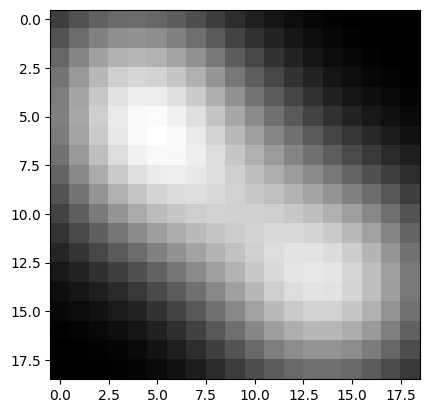

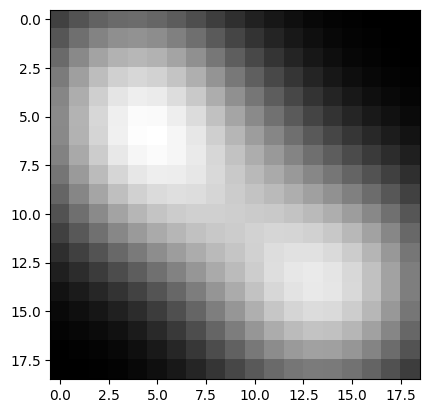

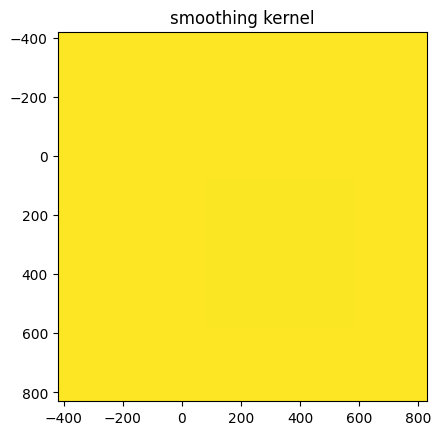

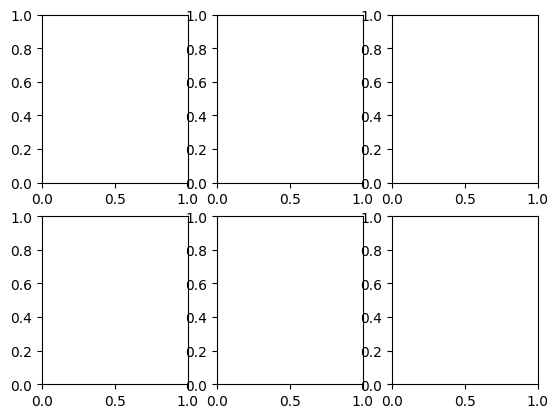

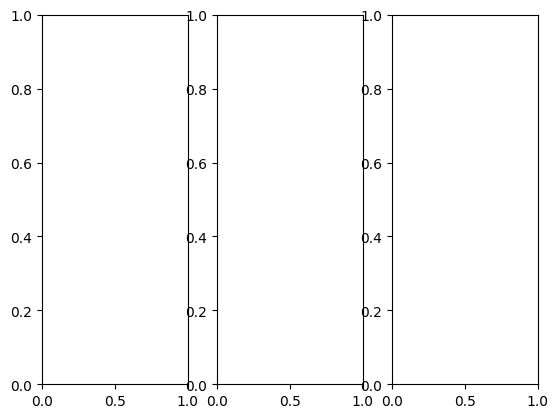

In [17]:
STalign_alignment_work_dir = os.path.join(work_dir, 'STalign')
if not os.path.exists(STalign_alignment_work_dir):
    os.makedirs(STalign_alignment_work_dir)
_b_prime = process(a,b_prime)
b_predict = hacca.direct_alignment(a, _b_prime, STalign_alignment_work_dir)
pi = hacca.direct_alignment_metric(a, _b_prime)
hacca.plot_b_predict(b_predict, STalign_alignment_work_dir)
STalign_alignment_loss = hacca.loss(b_predict, b_truth)
STalign_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(a, _b_prime, pi)
print(f"Run STalign_alignment: loss: {STalign_alignment_loss}, pairwise_alignment_accuracy: {STalign_pairwise_alignment_accuracy}")

In [16]:
def process(a,b_prime):
    import matplotlib.pyplot as plt
    xJ = a.D[:, 0]
    yJ = a.D[:, 1]
    xI = b_prime.D[:, 0]
    yI = b_prime.D[:, 1]
    XI,YI,I,fig = STalign.rasterize(xI,yI,dx=30,blur=1.5)
    XJ,YJ,J,fig = STalign.rasterize(xJ,yJ,dx=30, blur=1.5)
    extentI = STalign.extent_from_x((YI,XI))
    extentJ = STalign.extent_from_x((YJ,XJ))
    # run LDDMM
    # specify device (default device for STalign.LDDMM is cpu)
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    
    # keep all other parameters default
    params = {
                'niter': 1000,
                'device':device,
                'epV': 50
              }
    
    out = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)
    # get necessary output variables
    A = out['A']
    v = out['v']
    xv = out['xv']
    # set device for building tensors
    if torch.cuda.is_available():
        torch.set_default_device('cuda:0')
    else:
        torch.set_default_device('cpu')
        # apply transform
    phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
    phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
    
    #switch tensor from cuda to cpu for plotting with numpy
    if phii.is_cuda:
        phii = phii.cpu()
    if phiI.is_cuda:
        phiI = phiI.cpu()
    # transform is invertible
    phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
    phiiJ = STalign.transform_image_target_to_source(xv,v,A,[YJ,XJ],J,[YI,XI])
    
    #switch tensor from cuda to cpu for plotting with numpy
    if phi.is_cuda:
        phi = phi.cpu()
    if phiiJ.is_cuda:
        phiiJ = phiiJ.cpu()
    # apply transform to original points
    tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], 1).astype(np.double))
    
    #switch tensor from cuda to cpu for plotting with numpy
    if tpointsI.is_cuda:
        tpointsI = tpointsI.cpu()
    
    #switch from row column coordinates (y,x) to (x,y)
    xI_LDDMM = tpointsI[:,1]
    yI_LDDMM = tpointsI[:,0]
    df3 = pd.DataFrame(
    
        {
    
            "x": xI_LDDMM,
    
            "y": yI_LDDMM,
           
        },
    
    )
    b_prime.D=df3.to_numpy()
   

    return b_prime


Let's compare the performance of these alignment algorithms (alignment pieplines 1-8)

In [18]:
print(f"haCCA: loss: {haCCA}, pairwise_alignment_accuracy: {hacca_pairwise_alignment_accuracy}")
print(f"FWG2D-ICP3D alignment: loss: {ICD2D_FGW3D_alignment_loss}, pairwise_alignment_accuracy: {ICD2D_FGW3D_pairwise_alignment_accuracy}")
print(f"manual_alignment: loss: {manual_alignment}, pairwise_alignment_accuracy: {manual_alignment_pairwise_alignment_accuracy}")
print(f"Direct alignment: loss: {direct_alignment_loss}, pairwise_alignment_accuracy: {direct_alignment_pairwise_alignment_accuracy}")
print(f"ICP 2D: loss: {icp_2d_loss}, pairwise_alignment_accuracy: {icp_2d_dir_pairwise_alignment_accuracy}")
print(f"FGW 2D: loss: {fgw_2d_loss}, pairwise_alignment_accuracy: {fgw_2d_pairwise_alignment_accuracy}")
print(f"FGW 3D: loss: {fgw_3d_loss}, pairwise_alignment_accuracy: {fgw_3d_pairwise_alignment_accuracy}")
print(f"ICP 3D: loss: {icp_3d_loss}, pairwise_alignment_accuracy: {icp_3d_pairwise_alignment_accuracy}")
print(f"STalign_alignment: loss: {STalign_alignment_loss}, pairwise_alignment_accuracy: {STalign_pairwise_alignment_accuracy}")

haCCA: loss: (73.672745, 0.628, 0.4545776160648807), pairwise_alignment_accuracy: 0.6366530663673414
FWG2D-ICP3D alignment: loss: (55.991516, 0.883, 0.8192961476264753), pairwise_alignment_accuracy: 0.8808597762260466
manual_alignment: loss: (82.83608, 0.642, 0.459522054046258), pairwise_alignment_accuracy: 0.6455208333795347
Direct alignment: loss: (71.50197, 0.762, 0.6593195054939169), pairwise_alignment_accuracy: 0.7682690115142057
ICP 2D: loss: (66.407074, 0.797, 0.6959981683124736), pairwise_alignment_accuracy: 0.794045140908215
FGW 2D: loss: (55.991516, 0.883, 0.8192961476264753), pairwise_alignment_accuracy: 0.8808742971661894
FGW 3D: loss: (106.13354, 0.444, 0.2365601046736677), pairwise_alignment_accuracy: 0.44335860758901874
ICP 3D: loss: (64.11106, 0.798, 0.6989669635887983), pairwise_alignment_accuracy: 0.7980583501936018


NameError: name 'STalign_alignment_loss' is not defined